<a href="https://colab.research.google.com/github/eleciawhite/origami/blob/main/LangTiling/YoshiSines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script explores how origami can be made of Yoshimura patterns and curved crease. 

You may want to look at my [KateTess collab](https://colab.research.google.com/drive/1fzYIjLuT9UMiUwyxtAOIls0isZT1IvX4?usp=sharing) first as there is some overlap in functions and that is better documented. 

In [ ]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
from matplotlib.patches import Ellipse, Wedge, Polygon
from matplotlib.path import Path
import matplotlib
import itertools

from scipy.spatial import distance
from scipy import signal
import scipy
from google.colab import files


I want to be able to use the Amanda Ghassaei's [Origami Simulator](https://origamisimulator.org/) to test the output of the script. 

In this next block, I'm fixing up the matplotlib output to be more compatible with the simulator.

In [ ]:
indef = False
def rm_clippath(line):
  global indef

  if not indef:
    f = line.find('<clipPath')
  else:
    f = line.find('</clipPath>')
  if f >= 0:
    indef = not indef
    return ""
  if indef: return ""

  f = line.find('clip-path')
  if (f < 0): return line
  fc = line.find('"', f) + 1
  fe = line.find('"', fc) +1
  return line[:f]+line[fe:]

def fixup_svg(infile):
  global indef
  indef = False
  outfile = "kt_"+ infile
  replace_list = [['fill:none;',""], ['style="fill:#ffffff;"/>','style="fill:none;stroke:#000000"/>' ]]
  with open(infile) as fin, open(outfile, "w+") as fout:
    for line in fin:
      line = rm_clippath(line)
      for pair in replace_list:
        line = line.replace(pair[0], pair[1])
      fout.write(line)
  return outfile

def save_fig(name):
#  plt.axis('equal') # sometimes you need this but you can put it before save_fig
  plt.axis('off')
  plt.savefig(name + ".svg", bbox_inches = 'tight')
  outputfilename = fixup_svg(name + ".svg")
  files.download(outputfilename)

In [ ]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

Yoshimura patterns ([see Schwarz Lantern on Wikipedia](https://en.wikipedia.org/w/index.php?title=Yoshimura_fold&redirect=yes)) are related to Miura Ori patterns ([Wiki](https://en.wikipedia.org/wiki/Miura_fold)). With straight line creases, they can be folded flat and expanded like the solar panels of a space craft.

When you add curves to this, the flat fold goes away but the pattern is lovely.

This function only creates one set of lines but below are some to stack more lines.

In [ ]:
# Yoshimura and sines
def yoshimuraSine(name, start, horizLen, freq, angleDeg, amplitude, 
                  verticalOffset = 0,
                  numpoints=100, normalize = True, 
                  roll = 0, save = False):
  angle = radians(angleDeg)
  diagLen = 2.0*np.sin(angle)*horizLen/np.sin(np.pi - 2.0 * angle)
  height = (horizLen/2.0)*tan(angle)

  horizT = np.linspace(start, start + horizLen, numpoints)
  diagT = np.linspace(start, start + diagLen, numpoints)

  horiz = amplitude * np.sin( freq * horizT)
  
  diagF = freq
  if normalize:
    diagF = freq * ( diagLen / horizLen ) 
  diag = amplitude * np.sin( diagF * diagT )


  plt.plot(horizT + roll, horiz + verticalOffset, 'r') 
  plt.plot(horizT + roll, horiz + verticalOffset + height, 'r') 

  diag = np.hstack((np.vstack(diagT), np.vstack(diag)))
  origin=(diag[0])
  diagUp = rotate(diag, origin=origin, degrees=angleDeg)
  diagDown = rotate(diag, origin=origin, degrees=-angleDeg)
  plt.plot(diagUp[:,0] + roll, diagUp[:, 1] + verticalOffset, 'b') 
  plt.plot(diagDown[:,0] + roll, diagDown[:, 1] + verticalOffset, 'b') 

  ax = plt.gca()
  ax.set_aspect('equal', adjustable='box')
  plt.axis('off')

  if (save):
    save_fig("yoshi_{}_deg{}_amp{}_freq{}".
           format(name,angleDeg, amplitude, freq))
    
  return (2*height) + verticalOffset

For pics of the following, see [Cricut Project Yoshimura Sines 1](https://design.cricut.com/landing/project-detail/63de9a7ff77e7d594e5ef648).

1.1078950944467654

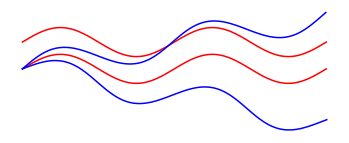

In [ ]:
download = False
yoshimuraSine("0off_2pi_n_", start = 0, horizLen = 2*np.pi, 
                          freq = 2, angleDeg = 10, amplitude = 0.3, 
                          normalize=False, save=download)

2.119031001295915

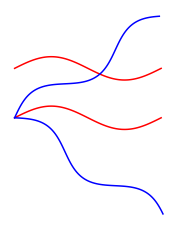

In [ ]:
yoshimuraSine("0off_2pi_n", 0, 1*np.pi, 2, 34, 0.25, normalize=True, save=download)

Stack some of those on top of each other to get a better picture. Allow for a change in where the pattern starts...

In [ ]:
def shiftingYoshiSines(name, start, hlen, hshift, iterations, 
                       freq, angleDeg, amplitude, normalize,
                       roll = 0,
                       save = True):
  verticalOffset = 0

  while iterations > 0:
    horizLen = hlen + iterations * hshift 
    verticalOffset = yoshimuraSine("", start = start, horizLen = horizLen, 
                          freq = freq, angleDeg = angleDeg, 
                          amplitude = amplitude, 
                          verticalOffset = verticalOffset,
                          normalize=normalize, roll = roll, save=False)
    start = (start + hshift)
    iterations -= 1
  # end while
  start -= hshift # undo the last one
  plt.xlim([start, horizLen+start])
  ax = plt.gca()
  ax.set_aspect('equal', adjustable='box')
  if (save): 
    save_fig("yoshiShift_{}_off{}_deg{}_amp{}_freq{}_norm{}".
           format(name, round(hshift,2),
                  angleDeg, amplitude, freq, normalize))



Before I show the shifting, make a normal one with no offset

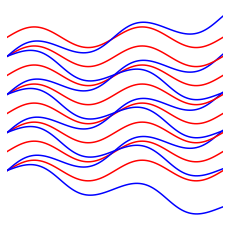

In [ ]:
download = False
shiftingYoshiSines("", 0, 2*np.pi, 0, iterations = 4, 
                  freq = 2, angleDeg = 10, amplitude = 0.3,
                   normalize=False, save=download)


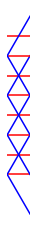

In [ ]:
download = False
shiftingYoshiSines("straight_", 0, 4*np.pi, 0, iterations = 4, 
                  freq = 10, angleDeg = 60, amplitude = 0,
                   normalize=False, save=download)


Another one that came out pretty neat... it looks like acorns and folds into an arch like a straightline version of Yoshimura folds.

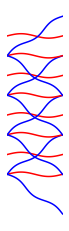

In [ ]:
download = False
# kt_yoshi_0off_2pi_n__deg34_amp0.25_freq1
shiftingYoshiSines("", start = 0, hlen = 2*np.pi, hshift = 0, iterations = 4, 
                  freq = 1, angleDeg = 35.5, amplitude = 0.25,
                   normalize=True, save=download)


Of course, this can be used to make straight line Yoshimura patterns as well.

In [ ]:
shiftingYoshiSines("straight", start = 0, hlen = 1*np.pi, hshift = 0, iterations = 8, 
                  freq = 1, angleDeg = 20, amplitude = 0,
                   normalize=False, save=download)


Let's get shifty! The crosspoint isn't perfect here. And the offset doesn't make as much difference as expected so I think there are some bugs above.

The blue moves but the red doesn't... hmmm... that wasn't what I was goingn for but it is kind of interesting...

> Indented block



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

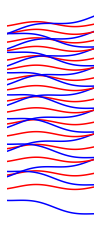

In [ ]:
download = True
shiftingYoshiSines("x", 0, 4*np.pi, 0.5*np.pi, iterations = 8, 
                  freq = 0.5, angleDeg = 10, amplitude = 0.4,
                   normalize=False, save=download)



By changing the horizontal length, the crossover point was changing. You can see it exaggerated with



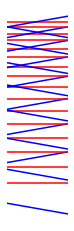

In [ ]:
shiftingYoshiSines("straight", 0, 8*np.pi, 3*np.pi, iterations = 8, 
                  freq = 1, angleDeg = 10, amplitude = 0,
                   normalize=False, save=download)

I only want to change where the sine was when it started so keeping the horizontal length constant, try shifting over values.

In [ ]:
def roll(self, curve, rollby):
  curve = np.copy(curve)
  nanarray = np.argwhere(np.isnan(curve))
  curve[1,:] = np.concatenate((curve[1,rollby:], curve[1,0:rollby]))
  for x,y in nanarray: # put back in discontinuities
    curve[x,y] = nan
  return curve

def yoshimuraSine(name, start, horizLen, freq, angleDeg, amplitude, 
                  verticalOffset = 0,
                  numpoints=1000, normalize = True, 
                  roll = 0, save = False):
  angle = radians(angleDeg)
  diagLen = 2.0*np.sin(angle)*horizLen/np.sin(np.pi - (2.0 * angle))
  height = (horizLen/2.0)*tan(angle)

  horizT = np.linspace(start, start + horizLen, numpoints)
  diagT = np.linspace(start, start + diagLen, numpoints)

  horiz = amplitude * np.sin( freq * horizT)
  
  diagF = freq
  if normalize:
    diagF = freq * ( diagLen / horizLen ) 
  diag = amplitude * np.sin( diagF * diagT )

  if roll != 0:
    rollby = floor((roll/start)*numpoints)
    horiz = np.concatenate((horiz[rollby:], horiz[0:rollby]))
    horizT += roll
    diag = np.concatenate((horiz[rollby:], horiz[0:rollby]))
    diagT += roll

  plt.plot(horizT, horiz + verticalOffset, 'r') 
  plt.plot(horizT, horiz + verticalOffset + height, 'r') 

  diag = np.hstack((np.vstack(diagT), np.vstack(diag)))
  origin=(diag[0])
  diagUp = rotate(diag, origin=origin, degrees=angleDeg)
  diagDown = rotate(diag, origin=origin, degrees=-angleDeg)

  plt.plot(diagUp[:,0], diagUp[:, 1] + verticalOffset, 'b') 
  plt.plot(diagDown[:,0], diagDown[:, 1] + verticalOffset, 'g') 
  ax = plt.gca()
  ax.set_aspect('equal', adjustable='box')
  plt.axis('off')

  if (save):
    save_fig("yoshi_{}_deg{}_amp{}_freq{}".
           format(name,angleDeg, amplitude, freq))
    
  return (2*height) + verticalOffset
  return plt.ylim()[1]-plt.ylim()[0]

In [ ]:
def shiftingYoshiSines2(name, start, hlen, hoffset, iterations, 
                       freq, angleDeg, amplitude, normalize,
                       save):
  verticalOffset = 0

  while iterations > 0:
    verticalOffset = yoshimuraSine("", start = start, horizLen = hlen, 
                          freq = freq, angleDeg = angleDeg, 
                          amplitude = amplitude, 
                          verticalOffset = verticalOffset,
                          roll = -start, normalize=normalize, save=False)
    start = (start + hoffset)
    iterations -= 1
  # end while
  start -= hoffset # undo the last one
  ax = plt.gca()
  ax.set_aspect('equal', adjustable='box')
  if (save): 
    save_fig("yoshiShift_{}_off{}_deg{}_amp{}_freq{}_norm{}".
           format(name, round(hoffset,2),
                  angleDeg, amplitude, freq, normalize))


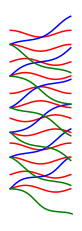

In [ ]:
download = False
shiftingYoshiSines2("hm", 0, 2*np.pi, .5*np.pi, iterations = 6, 
                  freq = 1, angleDeg =25, amplitude = .35,
                   normalize=True, save=download)


In [ ]:
def randYoshiSines(name, start, hlen, hoffset, iterations, 
                       freq, angleDeg, amplitude, normalize,
                       save):
  verticalOffset = 0

  while iterations > 0:
    verticalOffset = yoshimuraSine("", start = start, horizLen = hlen, 
                          freq = freq, angleDeg = angleDeg, 
                          amplitude = amplitude, 
                          roll = -start,
                          verticalOffset = verticalOffset,
                          normalize=normalize, save=False)
    start = hoffset * 2*(np.random.rand() - 0.5)
    print(start)

    iterations -= 1
  # end while
  ax = plt.gca()
  ax.set_aspect('equal', adjustable='box')
  if (save): 
    save_fig("yRand_{}_off{}_deg{}_amp{}_freq{}_norm{}".
           format(name, round(hoffset,2),
                  angleDeg, amplitude, freq, normalize))



2.3609772805482123
2.945089773158768
2.957585446978467
-1.9348234269773565
2.1305201897167216
0.23368906320395386
-1.7909563919481364
-0.9606342627807472


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

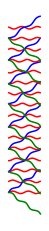

In [ ]:
download = True

randYoshiSines("5", 0, 2*np.pi, 1*np.pi, iterations = 8, 
                  freq = 2, angleDeg = 35, amplitude = 0.25,
                   normalize=False, save=download)
